In [1]:
#Importing modules, tools, etc.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.formula.api import ols

#importing main dataframe as df
df = pd.read_csv('data/kc_house_data.csv')

In [2]:
#Converting grade column to an int value

#Create a dummy list
grade_num = []

#Go through each row, grabbing the first index off the string, conver to int
for index, row in df.iterrows():
    grade_num.append(int((str(row['grade'])[0:2])))

#drop the old column and add the new
df['grade_num'] = grade_num
df.drop('grade', axis = 1)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,grade_num
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,7
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,7
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062,6
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,7
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509,8
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200,8
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007,7
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,...,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287,8


In [3]:
# Turning NaNs in the waterfront data into NO's, then converting waterfront to binary.
# 0 is a waterfront no, 1 is a waterfront yes
#

df.waterfront.fillna(value='NO', inplace = True)
df.waterfront.replace( to_replace = ['NO','YES'], value =  [0,1], inplace = True)

12764    13540
7245     12050
3910     10040
9245      9890
8085      9640
         ...  
11488      420
8614       410
21316      390
860        380
15367      370
Name: sqft_living, Length: 21597, dtype: int64
4980.0


<AxesSubplot:ylabel='Frequency'>

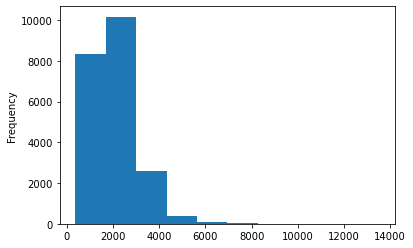

In [4]:
print(df['sqft_living'].sort_values(ascending = False))
#Those are some big results.
print(df['sqft_living'].quantile(0.99))
# even the 99 percentile is still sub 5000. 
df['sqft_living'].plot(kind = 'hist')
#Plotting this shows a bit skew right.


#It may be wise to shave the model off around there.

1717     1651359
17305    1164794
7640     1074218
7762     1024068
3945      982998
          ...   
20588        635
3449         609
7582         600
5821         572
15729        520
Name: sqft_lot, Length: 21597, dtype: int64
213008.0


<AxesSubplot:ylabel='Frequency'>

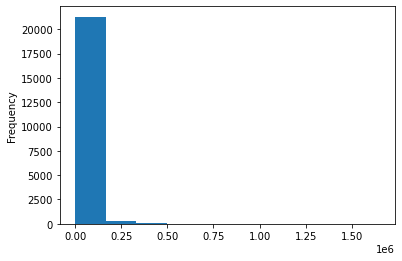

In [5]:
print(df['sqft_lot'].sort_values(ascending = False)) 
#Holy cow! I don't think those are residential sales.
print(df['sqft_lot'].quantile(0.99))
#99th quantile, still high, still well below those outliers

df['sqft_lot'].plot(kind = 'hist')
#Some weirdness at the far end

<AxesSubplot:ylabel='Frequency'>

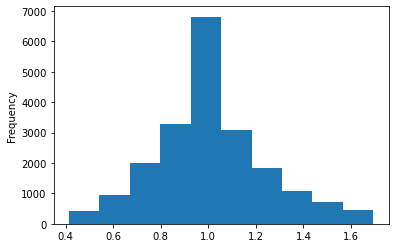

In [6]:
df.sqft_living.describe()
df['sqft_living_ratio'] = df['sqft_living'] / df['sqft_living15']
df.sqft_living_ratio.describe()


df['sqft_living_ratio'] = df.sqft_living / df.sqft_living15
df['sqft_living_ratio'] = df['sqft_living_ratio'].loc[(np.abs(stats.zscore(df.sqft_living_ratio)) < 2)]
df = df.dropna(subset = ['sqft_living_ratio'])
df.sqft_living_ratio.plot.hist()

count    20386.000000
mean         1.042518
std          0.312278
min          0.054972
25%          0.933333
50%          1.000000
75%          1.077654
max          3.275862
Name: sqft_lot_ratio, dtype: float64

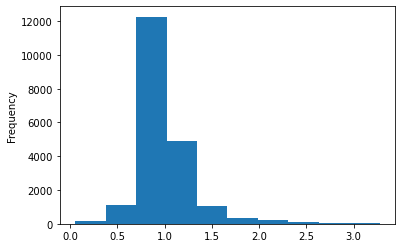

In [7]:
df.sqft_lot15.describe()
df['sqft_lot_ratio'] = df['sqft_lot'] / df['sqft_lot15']
df.sqft_lot_ratio.describe()

df['sqft_lot_ratio'] = df.sqft_lot / df.sqft_lot15
df['sqft_lot_ratio'] = df['sqft_lot_ratio'].loc[(np.abs(stats.zscore(df.sqft_lot_ratio)) < 2)]
df = df.dropna(subset = ['sqft_lot_ratio'])
df.sqft_lot_ratio.plot.hist()
df.sqft_lot_ratio.describe()

In [8]:
from statsmodels.formula.api import ols
X = df[['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode','sqft_living15', 'sqft_lot15', 'grade_num']]
y = df.price

In [9]:
formula = 'price~ bedrooms + bathrooms + sqft_living_ratio + sqft_lot_ratio + C(waterfront) + floors + C(zipcode) + grade_num'
regression = ols(formula, data = df).fit().summary()
regression

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     756.6
Date:                Tue, 16 Nov 2021   Prob (F-statistic):               0.00
Time:                        08:11:45   Log-Likelihood:            -2.7428e+05
No. Observations:               20386   AIC:                         5.487e+05
Df Residuals:                   20309   BIC:                         5.493e+05
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -9.223e+05   1.41e+04    -65.596      0.000    -9.5e+05   -8.95e+05
C(waterfront)[T.1]   8.752e+05   1.54e+04     56.929      0.000    8.45e+05    9.05e+05
C(zipcode)[T.98002]  4.824e+04   1.54e+04      3.139      0.002    1.81e+04    7.84e+04
C(zipcode)[T.98003] -2.008e+04   1.37e+04     -1.467      0.142   -4.69e+04    6743.224
C(zipcode)[T.98004]   7.93e+05   1.37e+04     57.854      0.000    7.66e+05     8.2e+05
C(zipcode)[T.98005]  3.229e+05   1.62e+04     19.954      0.000    2.91e+05    3.55e+05
C(zipcode)[T.98006]  3.307e+05   1.21e+04     27.421      0.000    3.07e+05    3.54e+05
C(zipcode)[T.98007]   2.33e+05    1.7e+04     13.719      0.000       2e+05    2.66e+05
C(zipcode)[T.98008]  2.572e+05   1.37e+04     18.743      0.000     2.3e+05    2.84e+05
C(zipcode)[T.98010]  1.306e+05   1.99e+04      6.568      0.000    9.16e+04     1.7e+05
C(zipcode)[T.98011]  1.329e+05   1.53e+04      8.694      0.000    1.03e+05    1.63e+05
C(zipcode)[T.98014]  1.585e+05   1.86e+04      8.542      0.000    1.22e+05    1.95e+05
C(zipcode)[T.98019]  1.199e+05   1.55e+04      7.744      0.000    8.95e+04     1.5e+05
C(zipcode)[T.98022]  4.912e+04   1.47e+04      3.337      0.001    2.03e+04     7.8e+04
C(zipcode)[T.98023] -4.216e+04   1.19e+04     -3.554      0.000   -6.54e+04   -1.89e+04
C(zipcode)[T.98024]  2.238e+05    2.3e+04      9.737      0.000    1.79e+05    2.69e+05
C(zipcode)[T.98027]  1.941e+05   1.25e+04     15.560      0.000     1.7e+05    2.19e+05
C(zipcode)[T.98028]  1.301e+05   1.37e+04      9.479      0.000    1.03e+05    1.57e+05
C(zipcode)[T.98029]  1.768e+05   1.32e+04     13.367      0.000    1.51e+05    2.03e+05
C(zipcode)[T.98030] -5391.4866   1.41e+04     -0.383      0.702    -3.3e+04    2.22e+04
C(zipcode)[T.98031]  1078.0547   1.38e+04      0.078      0.938    -2.6e+04    2.82e+04
C(zipcode)[T.98032]  3103.7515   1.79e+04      0.173      0.862    -3.2e+04    3.82e+04
C(zipcode)[T.98033]  3.698e+05   1.25e+04     29.689      0.000    3.45e+05    3.94e+05
C(zipcode)[T.98034]  1.909e+05   1.17e+04     16.371      0.000    1.68e+05    2.14e+05
C(zipcode)[T.98038]  4.277e+04   1.15e+04      3.710      0.000    2.02e+04    6.54e+04
C(zipcode)[T.98039]  1.224e+06   2.77e+04     44.166      0.000    1.17e+06    1.28e+06
C(zipcode)[T.98040]  5.845e+05   1.39e+04     41.985      0.000    5.57e+05    6.12e+05
C(zipcode)[T.98042]  9344.9133   1.17e+04      0.797      0.425   -1.36e+04    3.23e+04
C(zipcode)[T.98045]  1.164e+05    1.5e+04      7.747      0.000    8.69e+04    1.46e+05
C(zipcode)[T.98052]  2.269e+05   1.16e+04     19.578      0.000    2.04e+05     2.5e+05
C(zipcode)[T.98053]  2.467e+05   1.26e+04     19.659      0.000    2.22e+05    2.71e+05
C(zipcode)[T.98055]  5.476e+04    1.4e+04      3.913      0.000    2.73e+04    8.22e+04
C(z

In [10]:
df['floors'].value_counts()
#Seems reasonable. Maybe make it categorical?


1.0    10241
2.0     7673
1.5     1757
3.0      575
2.5      134
3.5        6
Name: floors, dtype: int64

<AxesSubplot:ylabel='Frequency'>

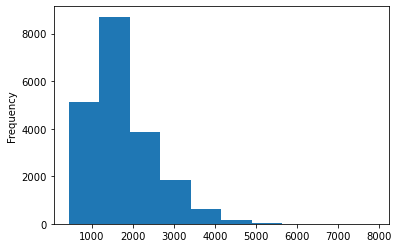

In [11]:
df['sqft_above'].sort_values(ascending = False) 
df['sqft_above'].quantile(.99)
#Not quite as extreme as sqft_livable


df['sqft_above'].plot(kind='hist')

In [ ]:
# Cleaning the basement data

df['sqft_basement'] = df['sqft_basement'].replace({'?': 0.0})
df['sqft_basement'] = df['sqft_basement'].astype(float)

In [ ]:
# Cleaning the view data
df['view'] = df['view'].replace({'NONE': 0, 'AVERAGE': 1, 'GOOD': 2, 'FAIR': 3, 'EXCELLENT':4})


In [12]:
df.price.describe()

count    2.038600e+04
mean     5.247194e+05
std      3.300028e+05
min      7.800000e+04
25%      3.199000e+05
50%      4.450000e+05
75%      6.280000e+05
max      4.210000e+06
Name: price, dtype: float64

In [13]:
df.price.value_counts().sort_index()

78000.0      1
81000.0      1
82000.0      1
83000.0      1
84000.0      1
            ..
3640000.0    1
3650000.0    2
3800000.0    2
3850000.0    1
4210000.0    1
Name: price, Length: 3505, dtype: int64

In [14]:
X = df[['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront','zipcode', 'grade_num']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

from sklearn.dummy import DummyRegressor
baseline = DummyRegressor()
baseline.fit(X_train, y_train)
print(baseline.score(X_test, y_test))

from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train,y_train)
print(linreg.score(X_train, y_train))
print(linreg.score(X_test, y_test))
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

from sklearn.metrics import mean_squared_error

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

# Calculate training and test MSE

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Root Mean Squarred Error:', np.sqrt(train_mse))
print('Test Root Mean Squarred Error:', np.sqrt(test_mse))

-0.0004392398544315057
0.5746811009434556
0.5649233862931775
Train Root Mean Squarred Error: 217256.70449382212
Test Root Mean Squarred Error: 211302.72462854083


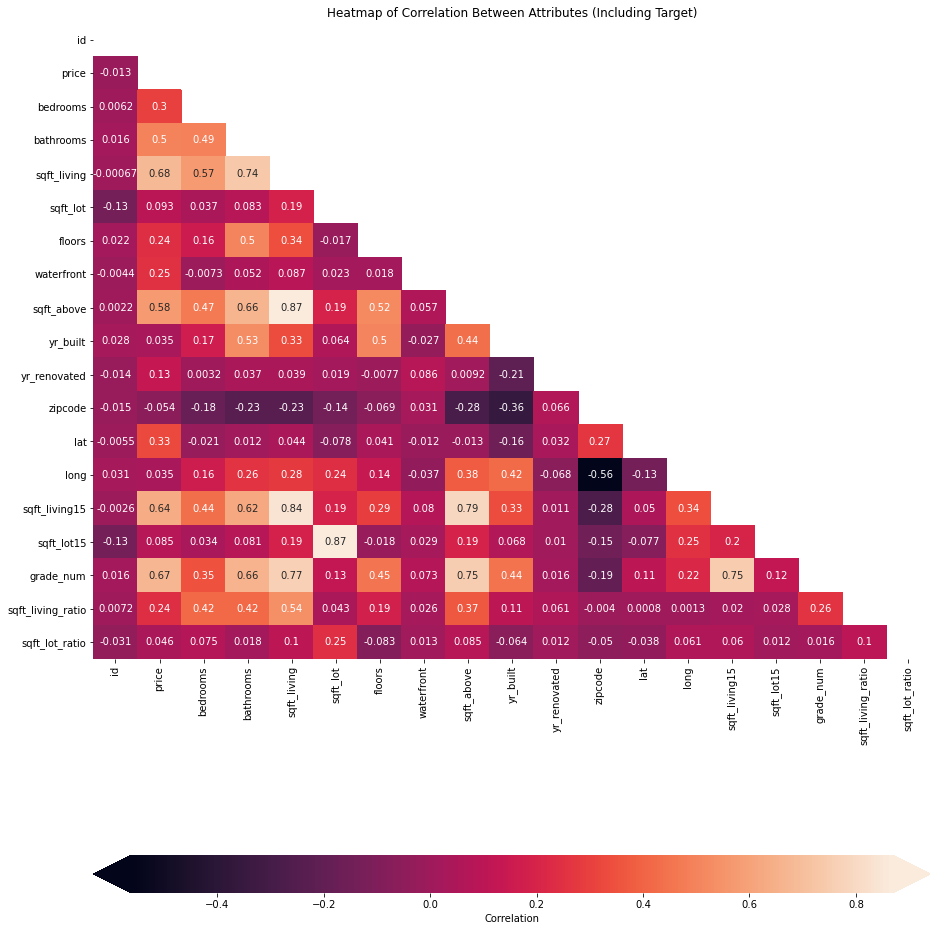

In [15]:
import seaborn as sns
import numpy as np

corr = df.corr()
fig, ax = plt.subplots(figsize=(15, 18))
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");